In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

import mne

from mne.io import read_raw_eeglab

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from sklearn.preprocessing import normalize

# change directory go into Notebooks folder
if os.path.basename(os.getcwd()) != 'Notebooks':
    if os.path.basename(os.getcwd()) == 'lib':
        os.chdir(os.path.join(os.getcwd(), '..', 'Notebooks'))
    else:
        os.chdir(os.path.join(os.getcwd(), 'Notebooks'))
else:
    # if already in Notebooks folder, do nothing
    pass

from lib import my_functions as mf

ModuleNotFoundError: No module named 'mne'

In [2]:
n_clusters = 5
ModK = ModKMeans(n_clusters=n_clusters, random_state=42)

In [3]:
id = 0

data_path = '../Data/'
folder_path = 'ica_rest_close/'
output_path = '../Output/' + folder_path
if not os.path.exists(output_path):
    os.makedirs(output_path)

id_name = f'{id:03d}'  # Format id as three digits
# id_name ='_all'
file_name = f's{id_name}.npy'

# load all data from rest_close
n_subjects = 1
all_data_close = []
all_y_close = []
for i in range(0, n_subjects):
    id_name = f'{i:03d}'  # Format id as three digits
    file_name = f's{id_name}.npy'
    data = mf.get_file_path(data_path, folder_path, file_name)
    all_data_close.append(data)
    file_name_y = f'y{id_name}.npy'
    data_y = mf.get_file_path(data_path, folder_path, file_name_y)
    for i in range(len(data_y)):
        if data_y[i] == 1:
            data_y[i] = 2
    all_y_close.append(data_y)

In [4]:
rest_ch_ls = ['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3',
                'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6',
                'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5',
                'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz',
                'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2']
sampling_rate = 250 # Hz

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Microstate colors

In [5]:

# Example values, adjust according to your data
eeg_data = np.array(all_data_close[0])
n_trials, _, n_channels, n_times = eeg_data.shape

info = mne.create_info(ch_names=rest_ch_ls, sfreq=sampling_rate, ch_types='eeg')
montage = mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

# Remove singleton dimension (if shape is (n_trials, 1, n_channels, n_times))
eeg_data = eeg_data[:, 0, :, :]  # shape becomes (n_trials, n_channels, n_times)

# Create MNE Epochs object
epochs = mne.EpochsArray(eeg_data, info)
# Extract Global Field Power (GFP) peaks to reduce number of samples
gfp_peaks = extract_gfp_peaks(epochs)




Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
# Initialize model
n_clusters = 5  # Choose based on your task
modkmeans = ModKMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
modkmeans.fit(gfp_peaks, n_jobs=-1)

# Predict microstate sequence for all epochs
microstate_sequence = modkmeans.predict(epochs)

c:\Users\josan\Documents\EPFL\These\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


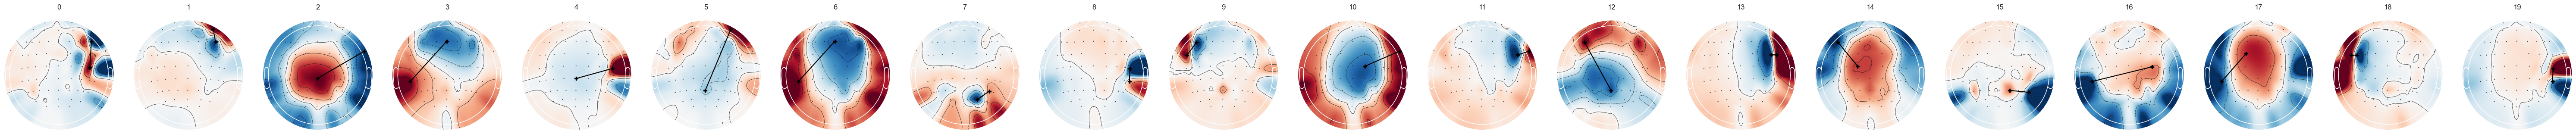

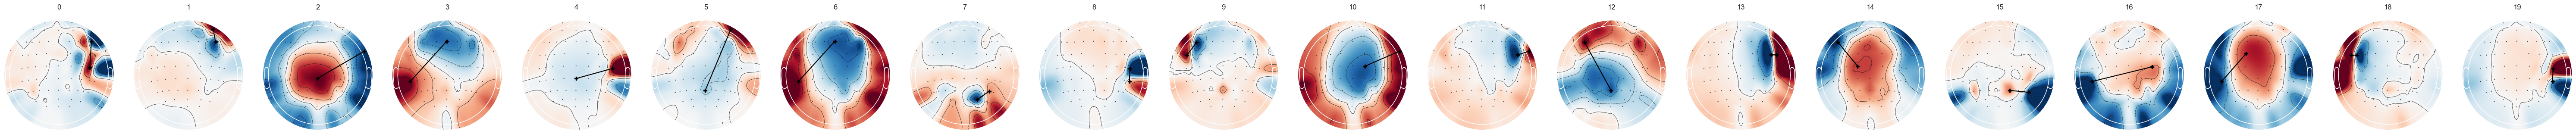

In [14]:
modkmeans.plot(show_gradient=True, show=False)  # plots the template microstates

In [9]:
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)
from pycrostates.preprocessing import extract_gfp_peaks


cluster_numbers = range(2, 4)
scores = {
    "GEV": np.zeros(len(cluster_numbers)),
    "Silhouette": np.zeros(len(cluster_numbers)),
    "Calinski-Harabasaz": np.zeros(len(cluster_numbers)),
    "Dunn": np.zeros(len(cluster_numbers)),
    "Davies-Bouldin": np.zeros(len(cluster_numbers)),
}

for k, n_clusters in enumerate(cluster_numbers):
    # fit K-means algorithm with a set number of cluster centers
    ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
    ModK.fit(gfp_peaks, n_jobs=-1, verbose="WARNING")

    # compute scores
    scores["GEV"][k] = ModK.GEV_
    scores["Silhouette"][k] = silhouette_score(ModK)
    scores["Calinski-Harabasaz"][k] = calinski_harabasz_score(ModK)
    scores["Dunn"][k] = dunn_score(ModK)
    scores["Davies-Bouldin"][k] = davies_bouldin_score(ModK)

    print(f"Scores for subject {id}, number of clusters {n_clusters}:")
    print(f"    GEV: {scores['GEV'][k]:.3f}")
    print(f"    Silhouette: {scores['Silhouette'][k]:.3f}")
    print(f"    Calinski-Harabasz: {scores['Calinski-Harabasaz'][k]:.3f}")
    print(f"    Dunn: {scores['Dunn'][k]:.3f}")
    print(f"    Davies-Bouldin: {scores['Davies-Bouldin'][k]:.3f}")

Scores for subject 0, number of clusters 2:
    GEV: 0.350
    Silhouette: 0.386
    Calinski-Harabasz: 4693.505
    Dunn: 0.000
    Davies-Bouldin: 8.446
Scores for subject 0, number of clusters 3:
    GEV: 0.404
    Silhouette: 0.346
    Calinski-Harabasz: 3355.346
    Dunn: 0.000
    Davies-Bouldin: 35.653


In [ ]:
# invert davies-bouldin scores
scores["Davies-Bouldin"] = 1 / (1 + scores["Davies-Bouldin"])

# normalize scores using sklearn
from sklearn.preprocessing import normalize
normalized_scores = {score: normalize(value[:, np.newaxis], axis=0).ravel()
        for score, value in scores.items()
        if score != "GEV"}  # Normalize all scores except GEV
scores.update(normalized_scores)
# set width of a bar and define colors
barWidth = 0.18
colors = sns.color_palette('colorblind', len(scores))  # Microstate colors

# create figure
plt.figure(figsize=(10, 8))
# create the position of the bars on the X-axis
x = [[elt + k * barWidth for elt in np.arange(len(cluster_numbers))]
     for k in range(len(scores))]
# create plots
for k, (score, values) in enumerate(scores.items()):
    plt.bar(
        x=x[k],
        height=values,
        width=barWidth,
        edgecolor="grey",
        color=colors[k],
        label=score,
    )
# add labels and legend
plt.title(f's{id}: Clustering scores for different number of clusters')
plt.xlabel("Number of clusters")
plt.ylabel("Score normalize to unit norm")
plt.xticks(
    [pos + 1.5 * barWidth for pos in range(len(cluster_numbers))],
    [str(k) for k in cluster_numbers],
)
plt.legend()
plt.tight_layout()
# save the model
output_file = os.path.join(output_path, 'scores', f'Cluster_score_s{id_name}.png')
if not os.path.exists(os.path.join(output_path, 'scores')):
    os.makedirs(os.path.join(output_path, 'scores'))
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.close()

output_file = os.path.join(output_path, 'scores', f'Cluster_score_s{id_name}.npy')
np.save(output_file, scores)

Scores for subject 0: {'GEV': array([0.35028655, 0.40355824]), 'Silhouette': array([0.74473514, 0.66736015]), 'Calinski-Harabasaz': array([0.81350041, 0.58156435]), 'Dunn': array([0.66203778, 0.74947047]), 'Davies-Bouldin': array([0.96835728, 0.249568  ])}


In [ ]:
scores

{'Silhouette': array([0.43284668, 0.38787565, 0.30839924, 0.31672162, 0.38720913,
        0.40357095, 0.3923941 ]),
 'Calinski-Harabasaz': array([0.62619495, 0.44766131, 0.35876987, 0.30332585, 0.24562382,
        0.26672655, 0.23512282]),
 'Dunn': array([0.04061319, 0.04597681, 0.98673404, 0.03666475, 0.10148263,
        0.10148263, 0.02551244]),
 'Davies-Bouldin': array([9.68357277e-01, 2.49567996e-01, 7.52305750e-17, 1.00606178e-16,
        1.26378323e-16, 1.95062429e-16, 1.81935730e-15])}